In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from datetime import datetime
import math
import statsmodels.api as sm

In [2]:
def bsm_calculator(timestamp: pd.Timestamp, future_spot: float, future_vol: float, strike: float) -> float:
    """Apply Black-Scholes-Merton to get fair value of ATM call.

    Args:
        timestamp (pd.Timestamp): Current pandas timestamp.
        future_spot (float): Predicted, future spot price value.
        future_vol (float): Predicted, future implied vol value.
        strike (float): Strike price of contract.

    Returns:
        float: Fair value of call with strike equal to current spot price (ATM), at some point in the future.
    """
    r = 0.05
    tte = (pd.Timestamp('12-31-2023') - timestamp).days/365
    d1 = (np.log(future_spot/strike) + (r + (future_vol**2)/2)*tte)/(future_vol*np.sqrt(tte))
    d2 = d1 - future_vol*np.sqrt(tte)
    return stats.norm.cdf(d1) * future_spot - stats.norm.cdf(d2)*strike*np.exp(-r*tte)

In [3]:
df = pd.read_csv("./durant/data.csv")
pred = pd.read_csv("./durant/sample_submission.csv")
df['t'] = pd.to_datetime(df['t'])
df["date"] = pd.to_datetime(df.t).dt.date.astype(str)
df["time"] = pd.to_datetime(df.t).dt.time.astype(str)

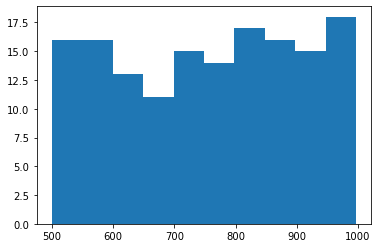

In [4]:
counts = df.groupby("date").count().values[:, 0]
plt.hist(counts)
plt.show()

In [5]:
names = ["spot_A","spot_B", "etf", "sigma_A", "sigma_B"]

for i in range(len(df)):
    if df.loc[i, "spot_A"] == -1 and df.loc[i, "spot_B"] != -1 and df.loc[i, "etf"] != -1:
        df.loc[i, "spot_A"] = df.loc[i, "etf"] - df.loc[i, "spot_B"]
    elif df.loc[i, "spot_B"] == -1 and df.loc[i, "spot_A"] != -1 and df.loc[i, "etf"] != -1:
        df.loc[i, "spot_B"] = df.loc[i, "etf"] - df.loc[i, "spot_A"]
    elif df.loc[i, "etf"] == -1 and df.loc[i, "spot_A"] != -1 and df.loc[i, "spot_B"] != -1:
        df.loc[i, "etf"] = df.loc[i, "spot_B"] + df.loc[i, "spot_A"]

for name in names:
    for i in range(len(df)):
        if df.loc[i,name] != -1:
            continue
        if df.loc[i-1]["date"] == df.loc[i]["date"]:
            df.loc[i,name] = df.loc[i - 1,name]

    for i in range(len(df) - 1, -1, -1):
        if df.loc[i,name] != -1:
            continue
        if df.loc[i + 1]["date"] == df.loc[i]["date"]:
            df.loc[i,name] = df.loc[i + 1,name]
    print(name)

spot_A
spot_B
etf
sigma_A
sigma_B


-0.35407650573234417
47.46741823265418


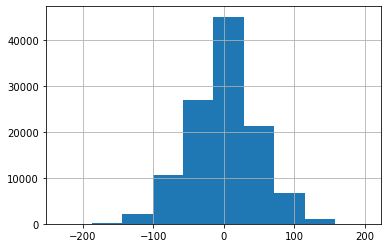

In [6]:
(df["etf"] - df["spot_A"] - df["spot_B"]).hist()
print((df["etf"] - df["spot_A"] - df["spot_B"]).mean())
print((df["etf"] - df["spot_A"] - df["spot_B"]).std())
plt.show()

In [7]:
df['etf_diff'] = df["etf"] - df["spot_A"] - df["spot_B"]

In [8]:
strikes = df.groupby('date').last()['spot_A']
times = df.groupby('date').last()['t']
vol = df.groupby('date').last()['sigma_A']

In [9]:
def func(x):
    return x[-500:].mean()
def var_func(x):
    return x[-500:].var()

In [10]:
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

Aspot_trend = df.groupby('date').spot_A.apply(lambda x : func(x))
Bspot_trend = df.groupby('date').spot_B.apply(lambda x : func(x))
etf_trend = df.groupby('date').etf.mean()

A_trend = gaussian_filter(Aspot_trend, sigma = 5)
B_trend = gaussian_filter(Bspot_trend, sigma = 5)
etf_trend = gaussian_filter(etf_trend, sigma = 5)

trend_df = pd.DataFrame(A_trend, columns = ['A_trend'])
trend_df.index = Aspot_trend.index
trend_df['B_trend'] = B_trend
trend_df['etf_trend'] = etf_trend
trend_df = trend_df.reset_index()
df = pd.merge(df, trend_df, on = ['date'])

/var/folders/7s/6wrlqwfs5y1g71y3cg83c94c0000gn/T/ipykernel_63994/2489322079.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return x[-500:].mean()
/var/folders/7s/6wrlqwfs5y1g71y3cg83c94c0000gn/T/ipykernel_63994/2489322079.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return x[-500:].mean()


In [11]:
sigma_trend = df.groupby('date').sigma_A.mean()
sigma_trend = pd.DataFrame(gaussian_filter(sigma_trend, sigma= 10), columns = ['sigma_A_trend'])
sigma_trend.index = Aspot_trend.index
sigma_trend = sigma_trend.reset_index()
df = pd.merge(df, sigma_trend, on = ['date'])

In [12]:
trends = pd.merge(trend_df, sigma_trend, on = ['date'])

In [13]:
trends['strike'] = strikes.values
trends['time'] = times.values
trends['vol'] = vol.values

In [14]:
trends

,date,A_trend,B_trend,etf_trend,sigma_A_trend,strike,time,vol
0,2022-10-01,218.038155,148.493518,366.135905,0.211868,219.930767,2022-10-01 10:19:00,0.161212
1,2022-10-02,218.051004,148.465568,366.114082,0.211832,218.850921,2022-10-02 09:40:00,0.158851
2,2022-10-03,218.076605,148.411213,366.071265,0.211758,221.562771,2022-10-03 13:29:00,0.243387
3,2022-10-04,218.114590,148.333315,366.009124,0.211650,218.029213,2022-10-04 13:13:00,0.090147
4,2022-10-05,218.164206,148.235727,365.930254,0.211508,210.116171,2022-10-05 15:36:00,0.352944
...,...,...,...,...,...,...,...,...
146,2023-02-24,193.454042,157.858596,351.745666,0.208797,192.514298,2023-02-24 16:28:00,0.079175
147,2023-02-25,193.354823,157.888357,351.769183,0.208656,194.586357,2023-02-25 14:50:00,0.279188
148,2023-02-26,193.275623,157.912065,351.792441,0.208551,193.476197,2023-02-26 13:23:00,0.090660
149,2023-02-27,193.220328,157.928580,351.810739,0.208481,193.909495,2023-02-27 10:31:00,0.111301


In [16]:
lst = []
for row in trends.iterrows():
    val = row[1]
    current_val = bsm_calculator(val['time'], val['strike'], val['vol'], val['strike'])
    future_val = bsm_calculator(val['time'] + pd.Timedelta(1, 'hour'), val['A_trend'], val['sigma_A_trend'], val['strike'])
    if future_val > current_val:
        lst.append(1)
    else:
        lst.append(0)
sum(lst)/len(lst)

0.5099337748344371

In [15]:
df['spot_A_d'] = df['spot_A'] - df['A_trend']
df['spot_B_d'] = df['spot_B'] - df['B_trend']
df['etf_d'] = df['etf'] - df['etf_trend']
df['sigma_A_d'] = df['sigma_A'] - df['sigma_A_trend']

In [16]:
fe = trends.copy()
x1 = df.groupby('date')['spot_B_d'].apply(lambda x : var_func(x)).values
x2 = df.groupby('date')['etf_d'].apply(lambda x : var_func(x)).values
x3 = df.groupby('date')['spot_A_d'].apply(lambda x : var_func(x)).values
fe['a_vol'] = x1
fe['etf_vol'] = x2
fe['b_vol'] = x3

fe['spot_b_d_mean'] = df.groupby('date')['spot_B_d'].mean().values
fe['etf_d_mean'] = df.groupby('date')['etf_d'].mean().values

fe['constant'] = 1

/var/folders/7s/6wrlqwfs5y1g71y3cg83c94c0000gn/T/ipykernel_63994/2489322079.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return x[-500:].var()
/var/folders/7s/6wrlqwfs5y1g71y3cg83c94c0000gn/T/ipykernel_63994/2489322079.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return x[-500:].var()
/var/folders/7s/6wrlqwfs5y1g71y3cg83c94c0000gn/T/ipykernel_63994/2489322079.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future ve

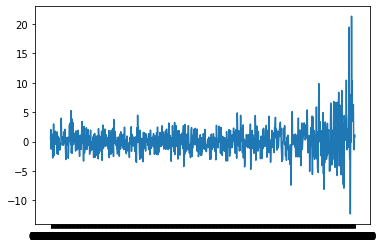

In [17]:
spot_data = df.groupby('time')['spot_A_d'].mean()
plt.plot(df.groupby('time')['spot_A_d'].mean())
plt.show()

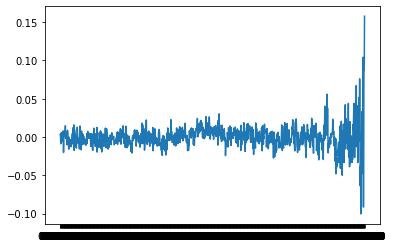

In [18]:
sigma_data = df.groupby('time')['sigma_A_d'].mean()
plt.plot(df.groupby('time')['sigma_A_d'].mean())
plt.show()

In [19]:
fe['count'] = df.groupby('date')['spot_A'].count().values

In [20]:
def get_spot_bin(count):
    return spot_data.iloc[count+60:].mean()
def get_sigma_bin(count):
    return sigma_data.iloc[count+60:].mean()

In [21]:
fe['spot_time_trend'] = fe['count'].apply(lambda x: get_spot_bin(x))
fe['sigma_time_trend']  = fe['count'].apply(lambda x: get_sigma_bin(x))

In [22]:
import statsmodels.api as sm
x1 = df.groupby('date')['spot_B_d'].apply(lambda x: var_func(x)).values
x2 = df.groupby('date')['etf_d'].apply(lambda x: var_func(x)).values
x3 = df.groupby('date')['spot_A_d'].apply(lambda x: var_func(x)).values
#x4 = df.groupby('date')['etf_diff'].mean().values
model_df = pd.DataFrame()
model_df['x1'] = x1
model_df['x2'] = x2
model_df['x3'] = x3
model_df['x4'] = x4
model_df['sigma_A_d'] = df.groupby('date')['sigma_A_d'].mean().values
model_df = model_df.dropna()
X = model_df[['x1','x3']]
X = sm.add_constant(X)
y = model_df['sigma_A_d'] 
mod = sm.OLS(y, X)
res_sigma = mod.fit()
res_sigma.summary()

/var/folders/7s/6wrlqwfs5y1g71y3cg83c94c0000gn/T/ipykernel_63994/2489322079.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return x[-500:].var()
/var/folders/7s/6wrlqwfs5y1g71y3cg83c94c0000gn/T/ipykernel_63994/2489322079.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return x[-500:].var()
/var/folders/7s/6wrlqwfs5y1g71y3cg83c94c0000gn/T/ipykernel_63994/2489322079.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future ve

NameError: name 'x4' is not defined

In [ ]:
import statsmodels.api as sm
x1 = df.groupby('date')['spot_B_d'].mean().values
x2 = df.groupby('date')['etf_d'].mean().values
x3 = df.groupby('date')['etf_diff'].mean().values
model_df = pd.DataFrame()
model_df['x1'] = x1
model_df['x2'] = x2
model_df['x3'] = x3
model_df['spot_A_d'] = df.groupby('date')['spot_A_d'].mean().values #- fe['spot_time_trend']
model_df = model_df.dropna()
X = model_df[['x1','x2', 'x3']]
X = sm.add_constant(X)
y = model_df['spot_A_d']
mod = sm.OLS(y, X)
res_spot = mod.fit()
res_spot.summary()

In [ ]:
fe['etf_diff'] = df.groupby('date')['etf_diff'].mean().values

In [71]:
fe['sigma_pred'] = fe['sigma_A_trend'] - 0.45 * res_sigma.predict(fe[['constant','b_vol','a_vol']])
fe['spot_pred'] = fe['A_trend'] + res_spot.predict(fe[['constant','spot_b_d_mean', 'etf_d_mean', 'etf_diff']])

In [72]:
lst2 = []
for row in fe.iterrows():
    val = row[1]
    current_val = bsm_calculator(val['time'], val['strike'], val['vol'], val['strike'])
    future_val = bsm_calculator(val['time'] + pd.Timedelta(1, 'hour'), val['spot_pred'], val['sigma_pred'], val['strike'])
    if future_val > current_val:
        lst2.append(1)
    else:
        lst2.append(0)

In [212]:
for i in range(len(lst2)):
    if lst[i] != lst2[i]:
        print(i)
#print(mean(lst2))

42
49
65
100
104
108
129


In [213]:
#fe['spot_pred'] = df.groupby('date')['spot_A'].mean().values
fe['spot_pred'] = fe['A_trend'] + res_spot.predict(fe[['constant','spot_b_d_mean', 'etf_d_mean', 'etf_diff']])
fe['sigma_pred'] = df.groupby('date')['sigma_A'].mean().values

lst2 = []
for row in fe.iterrows():
    val = row[1]
    current_val = bsm_calculator(val['time'], val['strike'], val['vol'], val['strike'])
    future_val = bsm_calculator(val['time'] + pd.Timedelta(1, 'hour'), val['spot_pred'], val['sigma_pred'], val['strike'])
    if future_val > current_val:
        lst2.append(1)
    else:
        lst2.append(0)

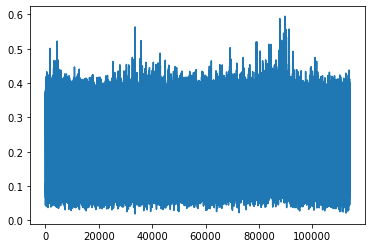

In [82]:
df['sigma_A'].plot()
plt.show()

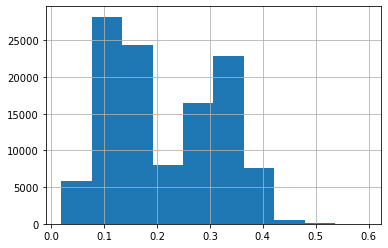

In [80]:
df['sigma_A'].hist()
plt.show()

In [83]:
df[df['sigma_A'] < 0.3]['sigma_A'].mean()

0.16011410598195017

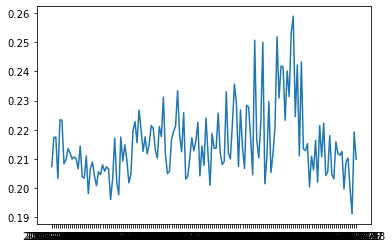

In [94]:
plt.plot(df.groupby('date')['sigma_A'].mean())
plt.show()

In [159]:
from scipy.optimize import curve_fit

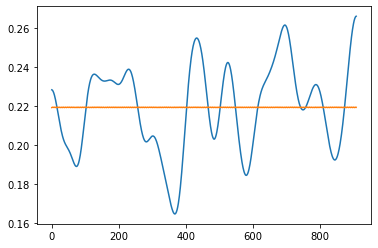

In [206]:
filtered_data = gaussian_filter(df.loc[df['date'] == '2022-11-30', 'sigma_A'], sigma = 20)
def sin_curve(x, a, b, c):
    return a + b * np.sin(x + c)

results = curve_fit(sin_curve, range(0, len(filtered_data)), filtered_data)
a, b, c = results[0]

file = pd.DataFrame()
file['data'] = range(0, len(filtered_data))


plt.plot(filtered_data)
plt.plot(file['data'].apply(lambda x : sin_curve(x, a, b, c)))
plt.show()

In [205]:
results

(array([ 2.19396522e-01, -1.88258021e-05,  1.18543559e+00]),
 array([[ 1.62283855e-08,  5.92652274e-12, -2.01195890e-06],
        [ 5.92652274e-12,  3.24215087e-08, -6.24694399e-07],
        [-2.01195890e-06, -6.24694399e-07,  9.49895657e+01]]))

In [84]:
df[df['sigma_A'] > 0.3]['sigma_A'].mean()

0.3449688000934983

In [216]:
final_csv = pd.DataFrame()
final_csv['Date'] = df.date.unique()
final_csv['Trade'] = lst2

In [217]:
final_csv['Trade'].mean()

0.5298013245033113

In [218]:
final_csv.to_csv('submission.csv', index = False)